# Introduction to representation learning

The main idea of representation learning is to transform data at our disposal and find a new representation of it in a new embedded space.
This new representation may be useful for several reasons, see the excellent article by Bengio et al. for more detailed explanations: https://arxiv.org/pdf/1206.5538.pdf.
Representations can then be used for a variety of machine learning tasks both supervised (such as prediction or classification) or unsupervised (such as clustering).

In this notebook, we are going to introduce basic ideas and methods behind representation learning, applied to the MNIST dataset.
It is a dataset that is made of images of handwritten digits and where each image is associated to the actual digit it represents.
Note that representation learning is by no means restricted to image datasets.
The latter are nonetheless particularly suited to illustrating techniques of representation learning as we can visualize the original data and their reconstruction (to be detailed below).

## Loading data

We are loading data from the MNIST dataset, it is one of the standard datasets used in `keras`, a handy Python framework for deep learning.
Each sample is an image, i.e. a matrix of size $n \times n = 28 \times 28 = 784$.
The set of all such matrices is denoted $X^{mat} \in \mathbb{R}^{n_{samples} \times n \times n}$, where $n_{samples}$ denotes the number of images available in the dataset.
Each image is associated to a label denoting the digit to which the image corresponds.
The set of all such labels is denoted $l \in \mathbb{R}^{n_{samples}}$.

As is standard in machine learning, the whole dataset must be split between a training dataset, used to train algorithms, and a test dataset, on which we evaluate the performance of our algorithms.
This is done automatically by the `keras` function `mnist.load_data()`.

We therefore load the MNIST dataset and split it as $(X^{mat}_{train}, l_{train})$ and $(X^{mat}_{test}, l_{test})$.

In [15]:
import keras
from keras.datasets import mnist
(X_mat_train, l_train), (X_mat_test, l_test) = mnist.load_data()

## Looking shapes of data

Let us first investigate:
- how the train and test sets have been split,
- what the dimensions of the data we loaded are.

In [16]:
n_samples_train = X_mat_train.shape[0]
n_samples_test = X_mat_test.shape[0]
n_samples = n_samples_train + n_samples_test
n = X_mat_train.shape[1]
print("n_samples_train / n_samples =", str(n_samples_train), "/", str(n_samples),
      "=", str(round(n_samples_train / n_samples, 2)))
print("n_samples_test / n_samples =", str(n_samples_test), "/", str(n_samples),
      "=", str(round(n_samples_test / n_samples, 2)))

n_samples_train / n_samples = 60000 / 70000 = 0.86
n_samples_test / n_samples = 10000 / 70000 = 0.14


In [17]:
print("Shape X_mat_train:", X_mat_train.shape)
print("Shape l_train:", l_train.shape)
print("Shape X_mat_test:", X_mat_test.shape)
print("Shape l_test:", l_test.shape)

Shape X_mat_train: (60000, 28, 28)
Shape l_train: (60000,)
Shape X_mat_test: (10000, 28, 28)
Shape l_test: (10000,)


## Visualizing data as matrices

We display 10 images of the training dataset to explore the latter.
All figures are displayed using `matplotlib.pyplot`. We also use a very convenient module `matplotlib.gridspec` which specifies how subplots of a figure are organized.

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

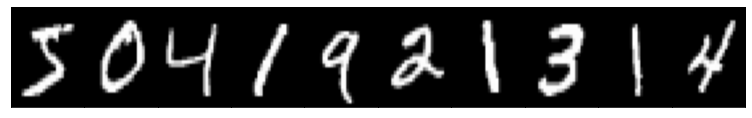

In [19]:
n_examples = 10
fig = plt.figure(figsize = (12, 2))
gs = gridspec.GridSpec(nrows = 1, ncols = n_examples, left = 0.1, bottom = 0.25, right = 0.95, top = 0.95,
                       wspace = 0.0, hspace = 0.0)
for i in range(0, n_examples):
    ax1 = plt.subplot(gs[i])
    plt.imshow(X_mat_train[i,:,:], cmap = "gray")
    ax1.set(adjustable = "datalim", aspect = "auto")
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

## Converting each matrix into a vector

In this notebook we are not going to take advantage of the 2 dimensional structure of the data.
Instead, we will convert all matrices of size $n \times n$ into vectors of size $d = n^2$.
Furtheremore, components of an image are originally comprised between 0 and 255; we want to work with data between 0 and 1 and thus normalize accordingly.

We obtain $X_{train} \in [0,1]^{n_{samples,train} \times d}$ and $X_{test} \in [0,1]^{n_{samples,test} \times d}$.

In [20]:
d = n * n
X_train = X_mat_train.reshape(n_samples_train, d) / 255
X_test = X_mat_test.reshape(n_samples_test, d) / 255

In [21]:
print("Shape X_train:", X_train.shape)
print("Shape l_train:", l_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape l_test:", l_test.shape)

Shape X_train: (60000, 784)
Shape l_train: (60000,)
Shape X_test: (10000, 784)
Shape l_test: (10000,)


## Principle of representation learning

Each sample $x \in \mathbb{R}^d$ of our dataset will be represented in a new space as $z \in \mathbb{R}^h$, with $h < d$, and will then be reconstructed in the original space as $y \in \mathbb{R}^d$ with some approximation, which is assessed by the reconstruction error $\epsilon(x) = \frac{1}{d} \sum_{j=1}^d | x_j - y_j |^2$.

The whole process can be summed up as:

$x \in \mathbb{R}^d \rightarrow z = f(x) \in \mathbb{R}^h \rightarrow y = g(f(x)) \in \mathbb{R}^d$

or matrix-wise:

$X \in \mathbb{R}^{n_{samples} \times d} \rightarrow Z = f(X) \in \mathbb{R}^{n_{samples} \times h} \rightarrow Y = g(f(X)) \in \mathbb{R}^{n_{samples} \times d}$

Learning the representation in the new embedded space $\mathbb{R}^{h}$ will be driven by how well we can reconstruct the original data $X$ as $Y$ by _going through_ the embedded space, i.e. the representation will be learnt by minimizing the reconstruction error over the whole dataset:

<center>$\epsilon(X) = \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} \frac{1}{d} \sum_{j=1}^d | X_{ij} - Y_{ij} |^2$.</center>

Specifying how we choose the functions $f$ and $g$ constitutes a model of representation learning. In the following, we will focus on Principal Component Analysis and Autoencoders.

## Principal Component Analysis (PCA)

Principal component analysis is one of the simplest technique to represent data in a space of reduced dimension.
Basically, it transforms the data to a new coordinate system such that the greatest variance by some projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on.
If we choose to keep only the first $h$ dimensions of this new coordinate system, we have a new representation of our data.

### Computing PCA by hand



We will perform a PCA on the training dataset.

In [22]:
m_train = X_train.mean(axis = 0)
print("Shape m_train: ", m_train.shape)

Shape m_train:  (784,)


The vector $m$ is the mean vector of each pixel. A PCA needs to be applied on a matrix with mean zero, we therefore define $X^0_{train}$ as:

In [23]:
X0_train = X_train - m_train

We perform an SVD decomposition of this centered matrix as $X^0_{train} = U \mathrm{Diag}(s) V^T$, with:
- $X^0_{train} \in \mathbb{R}^{n_{train} \times d}$,
- $U \in \mathbb{R}^{n_{train} \times n_{train}}$,
- $Diag(s) \in \mathbb{R}^{n_{train} \times d}$,
- $V \in \mathbb{R}^{d \times d}$.

An implementation of the SVD decomposition is available via the infamous `numpy` library.
For numerical efficiency, we set `full_matrices = False` in `np.linalg.svd`, which will reduce their dimensions to:
- $U \in \mathbb{R}^{n_{train} \times d}$,
- $Diag(s) \in \mathbb{R}^{d \times d}$,
- $V \in \mathbb{R}^{d \times d}$.

In [24]:
import numpy as np

U, s, V = np.linalg.svd(X0_train, full_matrices = False)
print("Shape U:", U.shape)
print("Shape s:", s.shape)
print("Shape V:", V.shape)

Shape U: (60000, 784)
Shape s: (784,)
Shape V: (784, 784)


We obtain the representation of our data in a new space of dimension $h$ by truncating the matrix $V$ and computing:

$Z^0_{train} = f(X^0_{train}) = X^0_{train} V_h^T \in \mathbb{R}^{n \times h}$,

where $V_h \in \mathbb{R}^{h\times d}$. Let's start with a small representation of $h = 2$.

In [25]:
h = 2
Vh = V[:h,:]
Z0_train = np.dot(X0_train, Vh.transpose())
print("Shape Z0_train:", Z0_train.shape)

Shape Z0_train: (60000, 2)


We then compute the reconstruction of our data from the representation space:

$Y^0_{train} = g(Z^0_{train}) = Z^0_{train} V_h$,

i.e.:

$Y^0_{train} = g(f(X^0_{train})) = X^0_{train} V_h^T V_h$.

In [26]:
Y0_train = np.dot(Z0_train, Vh)
print("Shape Y0_train:", Y0_train.shape)

Shape Y0_train: (60000, 784)


Let us not forget that we have computed the PCA of a zero mean matrix. We add back the mean of our data $m_{train}$ to obtain the final reconstruction $Y_{train}$.

In [27]:
Y_train = Y0_train + m_train

We can also reconstruct the test set as well, using the PCA matrices computed with the training set.

In [28]:
# m_test = X_test.mean(axis = 0)
m_test = m_train
X0_test = X_test - m_test
Z0_test = np.dot(X0_test, Vh.transpose())
Y0_test = np.dot(Z0_test, Vh)
Y_test = Y0_test + m_test

We can then compute the average reconstruction error on our data, for both the training set and the test set.

In [29]:
e_pca_train = np.sum((X_train - Y_train) ** 2) / d / n_samples_train
e_pca_test = np.sum((X_test - Y_test) ** 2) / d / n_samples_test
print("Homemade PCA training reconstruction error with h =", h, "PCs:", str(round(e_pca_train, 3)))
print("Homemade PCA test reconstruction error with h =", h, "PCs:", str(round(e_pca_test, 3)))

Homemade PCA training reconstruction error with h = 2 PCs: 0.056
Homemade PCA test reconstruction error with h = 2 PCs: 0.056


### Computing PCA using scikit-learn

It is rather important to understand how a PCA works behind the scenes, which is why we implemented it almost from scratch.
A PCA can nevertheless be computed automatically using `scikit-learn` and its `decomposition` module.

In [30]:
from sklearn.decomposition import PCA

h = 2
pca = PCA(n_components = h)
pca.fit(X0_train)

PCA(n_components=2)

We can notably check what the variance of our data in the new coordinate system along each axis is by printing `pca.explained_variance_`.

In [31]:
print("Explained variance for axes 1 and 2:", pca.explained_variance_)
print("Ratios of explained variance for axes 1 and 2:", pca.explained_variance_ratio_)
print("Total ratio of explained variance of the data in this new space:", np.sum(pca.explained_variance_ratio_))

Explained variance for axes 1 and 2: [5.11687301 3.74139083]
Ratios of explained variance for axes 1 and 2: [0.09704664 0.07095924]
Total ratio of explained variance of the data in this new space: 0.16800588413607076


Furtheremore, `pca.components_` plays the role of the matrix $V_h$ that we have introduced earlier.
We can therefore reconstruct the data and compute the reconstruction error which is, unsurprisingly, the same as the one computed earlier.

In [32]:
Z0_train = np.dot(X0_train, pca.components_.transpose())
Y0_train = np.dot(Z0_train[:,:h], pca.components_)
Y_train = Y0_train + m_train
e_pca_train = np.sum((X_train - Y_train) ** 2) / d / n_samples_train
print("SKL PCA reconstruction error with h =", h, "PCs:", str(round(e_pca_train, 3)))

SKL PCA reconstruction error with h = 2 PCs: 0.056


## Visualizing the reconstruction

As already mentioned, learning a representation of our data in a space of reduced dimension and reconstructing it in the original space can be done for various kinds of data.
However, one of the benefits of working with images is that we can visualize the reconstructed data and compare it to the original ones.
This is not always possible and it can be much harder to assess how well we have reconstructed data.

Let us see the reconstruction of our data in this case. We first need to convert our reconstructed vectors to matrices to display images, we hence define $Y^{mat}_{train} \in \mathbb{R}^{n_{samples} \times n \times n}$.

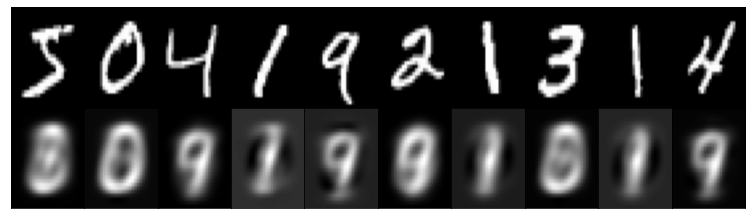

In [33]:
Y_mat_train = Y_train.reshape(60000, 28, 28)
n_examples = 10
fig = plt.figure(figsize = (12, 4))
gs = gridspec.GridSpec(nrows = 2, ncols = n_examples, left = 0.1, bottom = 0.25, right = 0.95, top = 0.95,
                       wspace = 0.0, hspace = 0.0)
for i in range(0, n_examples):
    ax1 = plt.subplot(gs[i])
    plt.imshow(X_mat_train[i,:,:], cmap = "gray")
    ax1.set(adjustable = "datalim", aspect = "auto")
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2 = plt.subplot(gs[n_examples+i])
    plt.imshow(Y_mat_train[i,:,:], cmap = "gray")
    ax2.set(adjustable = "datalim", aspect = "auto")
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

The reconstruction is not particularly good with $h = 2$ only.
There is actually nothing very surprising since the dimension of the representation space is very low, probably too low to explain all the information and variability of our data.

Let's try with several values of $h$ to see how the results change.
We are going to store all our results in dictionaries for convenience and reusability.
This is particularly important when working with lots of different models (it will be even more crucial for autoencoders).

Obviously, the maximum value for $h$ is $d$, that of the data itself.

For each value of $h$, we compute the PCA, the reconstruction error, the total ratio of variance explained, and we also display both the original image and the associated reconstruction image.

SKL PCA, h = 2 PCs, reconstruction error: 0.056 total ratio of variance explained: 0.168
SKL PCA, h = 5 PCs, reconstruction error: 0.045 total ratio of variance explained: 0.332
SKL PCA, h = 10 PCs, reconstruction error: 0.034 total ratio of variance explained: 0.488
SKL PCA, h = 20 PCs, reconstruction error: 0.024 total ratio of variance explained: 0.644
SKL PCA, h = 50 PCs, reconstruction error: 0.012 total ratio of variance explained: 0.825
SKL PCA, h = 100 PCs, reconstruction error: 0.006 total ratio of variance explained: 0.914
SKL PCA, h = 784 PCs, reconstruction error: 0.0 total ratio of variance explained: 1.0


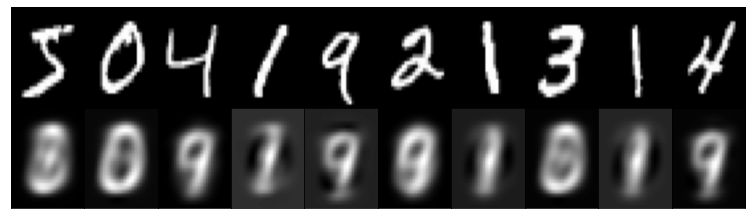

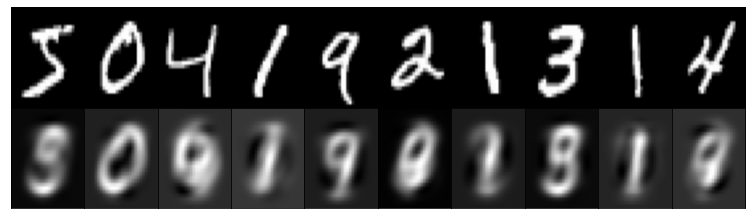

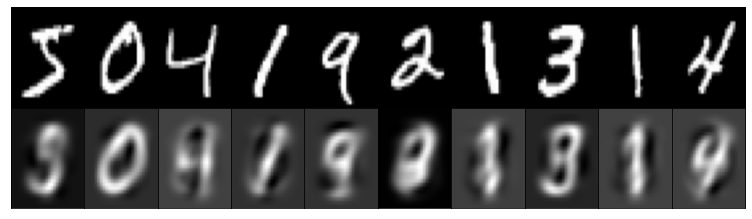

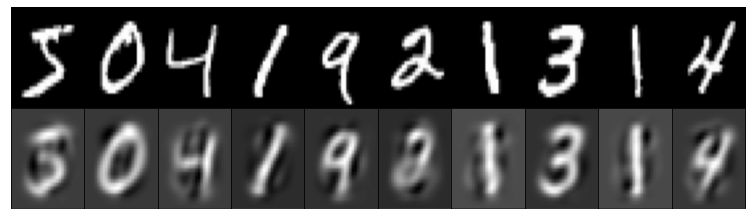

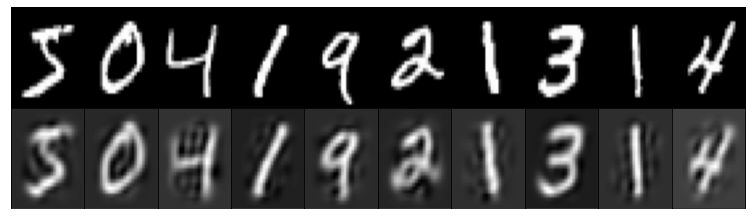

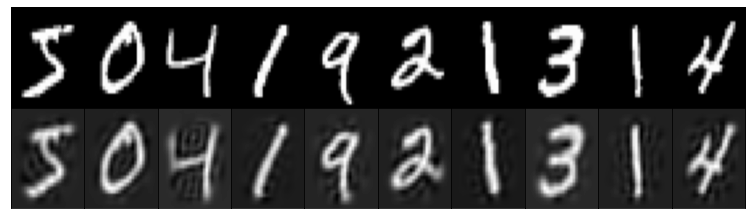

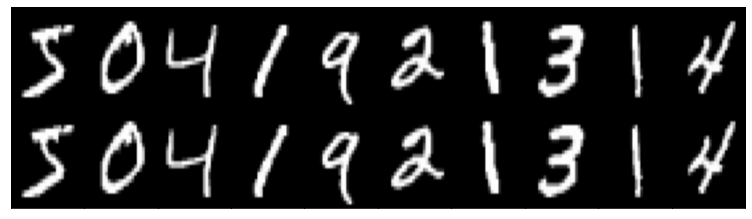

In [34]:
dict_pca = {}
dict_e_pca_train = {}
dict_var_exp_train = {}

for h in [2, 5, 10, 20, 50, 100, 784]:
    dict_pca[h] = PCA(n_components = h)
    dict_pca[h].fit(X0_train)
    pca = dict_pca[h]
    Z0_train = np.dot(X0_train, pca.components_.transpose())
    Y0_train = np.dot(Z0_train[:,:h], pca.components_)
    Y_train = Y0_train + m_train
    e_pca_train = np.sum((X_train - Y_train) ** 2) / d / n_samples_train
    var_exp_train = np.sum(pca.explained_variance_ratio_)
    dict_e_pca_train[h] = e_pca_train
    dict_var_exp_train[h] = var_exp_train
    print("SKL PCA, h =", h, "PCs, reconstruction error:", str(round(e_pca_train, 3)),
          "total ratio of variance explained:", str(round(var_exp_train, 3)))
    Y_mat_train = Y_train.reshape(n_samples_train, n, n)
    n_examples = 10
    fig = plt.figure(figsize = (12, 4))
    gs = gridspec.GridSpec(nrows = 2, ncols = n_examples, left = 0.1, bottom = 0.25, right = 0.95, top = 0.95,
                           wspace = 0.0, hspace = 0.0)
    for i in range(0, n_examples):
        ax1 = plt.subplot(gs[i])
        plt.imshow(X_mat_train[i,:,:], cmap = "gray")
        ax1.set(adjustable = "datalim", aspect = "auto")
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)
        ax2 = plt.subplot(gs[n_examples+i])
        plt.imshow(Y_mat_train[i,:,:], cmap = "gray")
        ax2.set(adjustable = "datalim", aspect = "auto")
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

Unsurprisingly, we see that results improve with increasing $h$ and that the reconstructed images start to look decent for $h = 20$. For $h = d$, the original image, the representation in the embedded space and the reconstruction are all the same!

## Data visualization

### Using PCA

A PCA with $h = 2$ allows to obtain a two dimensional representation of our data that we can then plot.
It is an interesting, easy and quick way (although slightly naive too!) to see how the data is distributed in this new space, whether clusters might be present or not, etc.
Let us apply this technique to the MNIST dataset.

In [35]:
pca = PCA(n_components = 2)
pca.fit(X0_train)
Z0_train_pca = np.dot(X0_train, pca.components_.transpose())

In order to have good looking figures, we define a bunch of `matplotlib` options.

In [36]:
n_digits = 10
fs = 20
plt.rc('axes', facecolor = "white", linewidth = 1, grid = False, edgecolor = "black",
       titlesize = fs, labelsize = fs)
plt.rc('font', size = fs)
plt.rc('xtick', labelsize = fs)
plt.rc('ytick', labelsize = fs)
plt.rc('legend', fontsize = fs)
plt.rc('figure', titlesize = fs, figsize = (15, 10))
colors = plt.cm.jet(np.linspace(0, 1, n_digits))

For each digit $k$ between 0 and 9, we find the indices in our training dataset which corresponds to $k$, and plot the representation of $n_{points} = 500$ points (so as not to overload the image) corresponding to this digit.

All instances of a given digit $k$ are displayed in the same color.

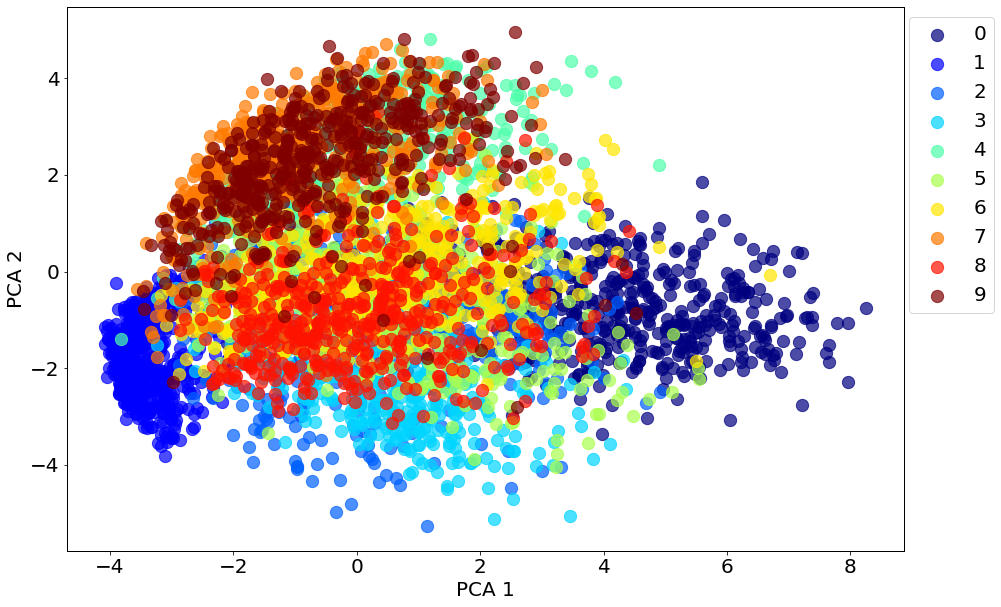

In [37]:
n_points = 500

fig = plt.figure()
for digit in range(0, 10):
    ind = np.where(l_train == digit)
    ind = ind[0][0:n_points]
    plt.scatter(Z0_train_pca[ind,0], Z0_train_pca[ind,1], label = str(digit), color =  colors[digit], alpha = 0.7, s = 150)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.12, 1.0))

We see that most instances of a given digit $k$ are grouped together, although there exist (possibly strong) overlaps between different groups of digits.

### Using t-SNE

Another technique worth mentioning to display data in 2 dimensions is t-distributed Stochastic Neighbor Embedding (t-SNE).
First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects have a high probability of being picked while dissimilar points have an extremely small probability of being picked.
It defines a similar probability distribution over the points in the low-dimensional map, and it then minimizes the Kullback–Leibler divergence between the two distributions with respect to the locations of the points in the map.

Since it can be numerically expensive, we only compute it on a subset of the training set of size `n_samples_tsne = 2000`. We also compute the required time to compute it using the `time` module.

In [38]:
import time
from sklearn.manifold import TSNE
r_tsne = TSNE(n_components = 2, perplexity = 50.0, early_exaggeration = 20.0)
n_samples_tsne = 2000 ## computing t-SNE over the whole dataset is rather costly
ti_tsne = time.time()
Z0_train_tsne = r_tsne.fit_transform(X0_train[0:n_samples_tsne,:])
t_tsne = time.time() - ti_tsne
print("Time TSNE with", n_samples_tsne, "samples:", str(round(t_tsne, 2)), "s")

c:\Users\macxp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\macxp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Time TSNE with 2000 samples: 8.36 s


We display the same kind of figure as for PCA.
You can play with the parameters of `perplexity` and `early_exaggeration` to see how it changes the plot.

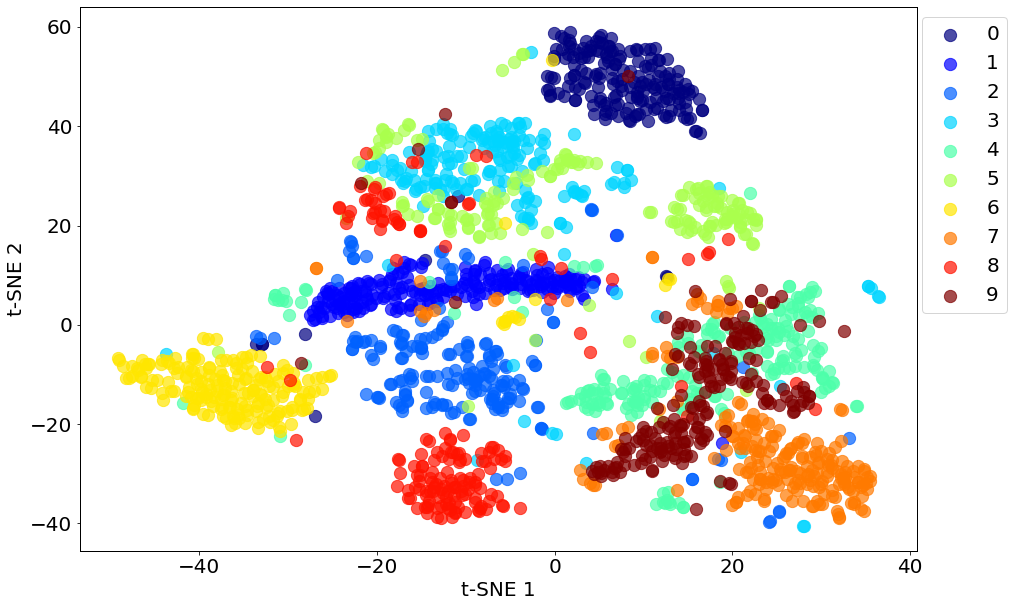

In [39]:
fig = plt.figure()
for digit in range(0, 10):
    ind = np.where(l_train[0:n_samples_tsne] == digit)
    plt.scatter(Z0_train_tsne[ind,0], Z0_train_tsne[ind,1], label = str(digit), color =  colors[digit], alpha = 0.7, s = 150)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
plt.legend(bbox_to_anchor=(1.12, 1.0))

Groups of digits appear to be much better separated than for PCA.
In this supervised case, where digit labels are available for confirmation, t-SNE appears very relevant.
In general, one must remain careful though:
while t-SNE plots often seem to display clusters, the visual clusters can be influenced strongly by the chosen parameterization and therefore a good understanding of the parameters for t-SNE is necessary. Such "clusters" can be shown to even appear in non-clustered data, and thus may be false findings. Interactive exploration may thus be necessary to choose parameters and validate results.

## Autoencoders

Let us recall that with a PCA we learn a representation as:

$Y^0_{train} = g(Z^0_{train}) = Z^0_{train} V_h$,

i.e.:

$Y^0_{train} = g(f(X^0_{train})) = X^0_{train} V_h^T V_h$.

Can we find other functions $f$ and $g$ so that the reconstruction error:

<center>$\epsilon(X) = \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} \frac{1}{d} \sum_{j=1}^d | X_{ij} - Y_{ij} |^2$.</center>

is even lower? This was indeed our a priori criterion to learn a good representation in the space of dimension $h$.

An autoencoder is a type of neural network that is comprised of two parts:
- an encoder, that _encodes_ the original data in a space of reduced dimension (this is our representation),
- a decoder, that _decodes_ the representation back in the original space.

Note that this is precisely what we have done so far with PCA, which is indeed equivalent to a particular architecture of an autoencoder.

### Simple autoencoder

An autoencoder is nothing more than a neural network with layers of weights and activation functions.
If $x$ is an input vector (let us recall that in our case this is a vectorized image), the most simple autoencoder can be written in the following way:
- encoder: $x \rightarrow z = f(x) = \sigma_1(W_1 x)$,
- decoder: $z \rightarrow y = g(z) = \sigma_2(W_2 z)$.

where $W_1$ and $\sigma_1$ (resp. $W_2$ and $\sigma_2$) are the weight matrix and the activation function of the first [encoder] layer (resp. the second [decoder] layer). The output of the autoencoder is then simply: $y = g(f(x)) = \sigma_2(W_2 \sigma_1 (W_1 x))$.

If we choose $W_1 = W_2^T = V_h^{PCA}$ and $\sigma_1 = \sigma_2 = Id$, we are left with nothing but the PCA model.
However, there may be better choices of $W_1$, $W_2$, $\sigma_1$ and $\sigma_2$ to minimize the reconstruction error $\epsilon$.

The strength of neural networks is that they are nonlinear thanks to the (usually nonlinear) activation functions.
In our case, once activation functions $\sigma_1$ and $\sigma_2$ are chosen, we can optimize the weights of the autoencoder so as to minimize the reconstruction error, i.e. we solve:

<center>$W_1, W_2 = \arg \min \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} \frac{1}{d} \sum_{j=1}^d | X_{ij} - Y_{ij} |^2$.</center>

where $Y = \sigma_2(W_2 \sigma_1 (W_1 X))$. This is done using backpropagation.

### Refined autoencoders

We can build autoencoders with more complicated architectures than the simple one we just described.
For instance, we might want to increase the depth of our network by adding other layers to both the encoder and decoder parts and the dimension of each layer need not be the same. It will comprise more layers, hence more weight matrices, but the principle remains the same:

<center>$\{W_l\}_{1 \leq l \leq L} = \arg \min \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} \frac{1}{d} \sum_{j=1}^d | X_{ij} - Y_{ij} |^2$,</center>

where $L$ is the number of layers of the model and $Y = \sigma_L(W_L \dots \sigma_1(W_1 X))$.

We now build an autoencoder with the following architecture:
- a layer with 512 units and activation function `elu`, followed by
- a layer with 128 units and activation function `elu`, followed by
- a layer with 2 units and a `linear` activation function, followed by
- a layer with 128 units and activation function `elu`, followed by
- a layer with 512 units and activation function `elu`, followed by
- a layer with 784 units and activation function `sigmoid`.
  
The last layer gives us the reconstructed data in the original space. Notice that we use a `sigmoid` function in order to have output data between 0 and 1, as for the input data (recall that we have scaled it in the very beginning of this notebook).

We use `keras` to build these autoencoders.
We first define a `Sequential()` `model` and `add` to it different (`Dense`) layers.

The last step of defining a `keras` model is to compile it by specifying the objective function, i.e. the loss, which is here the `mean_squared_error` between the input and the output of the model, i.e. precisely:

<center>$\arg \min \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} \frac{1}{d} \sum_{j=1}^d | X_{ij} - Y_{ij} |^2$.</center>

We also need to specify which optimizer we choose, `Adam()` in this case.

In [40]:
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(512, activation = "elu", input_shape = (784,)))
model.add(Dense(128, activation = "elu"))
model.add(Dense(2, activation = "linear", name = "representation"))
model.add(Dense(128, activation = "elu"))
model.add(Dense(512, activation = "elu"))
model.add(Dense(784, activation = "sigmoid"))
model.compile(loss = "mean_squared_error", optimizer = Adam())
history = model.fit(X_train, X_train, batch_size = 128, epochs = 5, verbose = 1,
                    validation_data = (X_test, X_test))

Epoch 1/5
469/469 [==============================] - 5s 9ms/step - loss: 0.0579 - val_loss: 0.0491
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0471 - val_loss: 0.0448
Epoch 3/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0437 - val_loss: 0.0426
Epoch 4/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0418 - val_loss: 0.0411
Epoch 5/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0408 - val_loss: 0.0405


We just (hopefully) successfully trained our first autoencoder. We may want to visualize the training history and the representation we have learnt, but if we want to study different architectures of autoencoders, we need an efficient and concise way of defining them.

### Building autoencoders in a generic and efficient way

Since we want to study different kinds of architectures in an efficient way, we are going to store once again all our results inside dictionaries.

In [41]:
dict_model = {}
dict_history = {}
dict_encoder = {}

Let us write a function `build_autoencoder` which takes as an input the string representing the architecture of our autoencoder. These strings will be the keys of the dictionaries. For instance `"512,elu-128,elu-2,Rlinear-128,elu-512,elu-784,sigmoid"` will build the architecture we just described.

If the activation function of a layer starts with `R`, we drop this `R` from the name of the activation function and name the layer `representation`, this will allow us later to easily retrieve the output of this particular layer since we are interested in the representation.

In [42]:
def split_arch(arch):
    layers = arch.split("-")
    return [layer.split(",") for layer in layers]

def build_autoencoder(arch, d):
    arch_split = split_arch(arch)
    layer0 = arch_split[0]
    model = Sequential()
    if layer0[1].startswith("R"):
        model.add(Dense(int(layer0[0]), activation = layer0[1][1:], name = "representation", input_shape = (d,)))
    else:
        model.add(Dense(int(layer0[0]), activation = layer0[1], input_shape = (d,)))
    for i in range(1, len(arch_split)):
        layer = arch_split[i]
        if layer[1].startswith("R"):
            model.add(Dense(int(layer[0]), activation = layer[1][1:], name = "representation"))
        else:
            model.add(Dense(int(layer[0]), activation = layer[1]))
    model.compile(loss = 'mean_squared_error', optimizer = Adam())
    return model

For different values of $h$, we define both a naive architecture of an autoencoder (with only 3 layers in total) and a more refined architecture.

### Training

In [43]:
archs = []
hs = [2, 20]
for h in hs:
    archs.append(str(h) + ",Rlinear-784,sigmoid")
    archs.append("512,elu-128,elu-" + str(h) + ",Rlinear-128,elu-512,elu-784,sigmoid")

We train all these autoencoders for 20 epochs and store their training history.

It actually takes some time to obtain all results, you can increase the number of dimensions for the representation space, say `hs = [2, 5, 10, 20, 50, 100, 784]`, and increase the number of epochs to 100 if you want to see the complete training.

Note that for refined autoencoders, there are many more weight parameters to learn, the training time is therefore much longer.

In [44]:
n_epochs = 20

## the full training can take ~15 minutes

ti_training = time.time()
for arch in archs:
    print(arch)
    dict_model[arch] = build_autoencoder(arch, d)
    dict_history[arch] = dict_model[arch].fit(X_train, X_train, batch_size = 128, epochs = n_epochs, verbose = 1, 
                                              validation_data = (X_test, X_test))
t_training = time.time() - ti_training
print("Time for training autoencoders:", t_training)

2,Rlinear-784,sigmoid
Epoch 1/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0893 - val_loss: 0.0691
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0646 - val_loss: 0.0618
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0611 - val_loss: 0.0604
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0599 - val_loss: 0.0594
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0591 - val_loss: 0.0588
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0586 - val_loss: 0.0583
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0582 - val_loss: 0.0579
Epoch 8/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0578 - val_loss: 0.0577
Epoch 9/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0576 - val_loss: 0.0575
Epoch 10/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0

For each size of the representation, we plot the training curves of both the simple autoencoders and the refined one. We also add to the plot the value of the PCA reconstruction error.

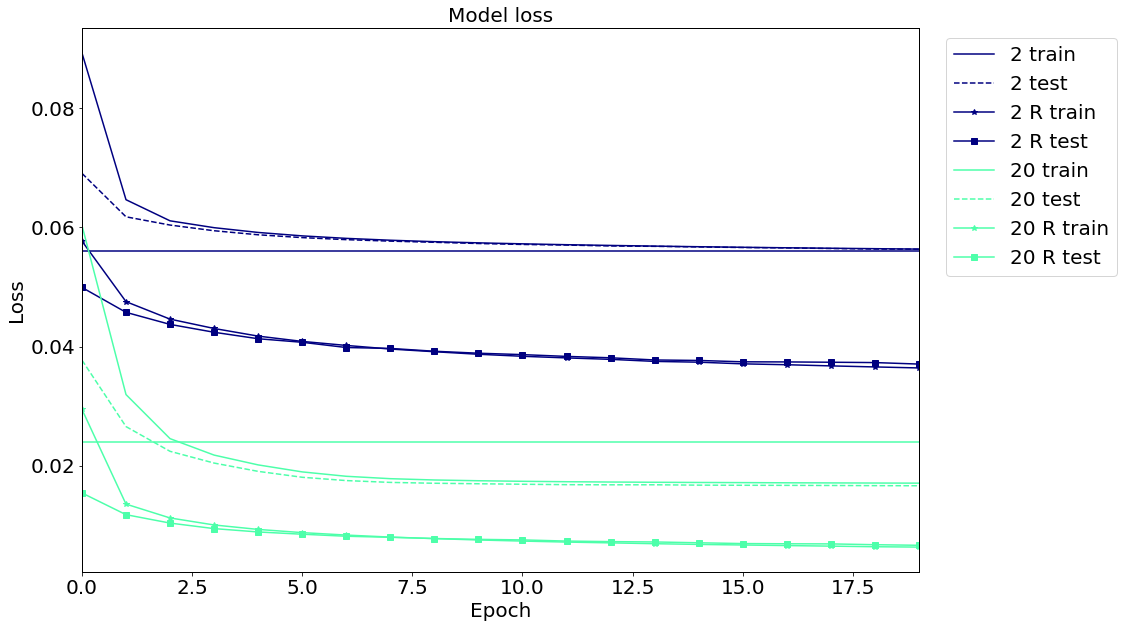

In [45]:
plt.figure()
i = 0
for h in hs:
    ci = colors[np.mod(4*i, len(colors))]
    arch = str(h) + ",Rlinear-784,sigmoid"
    history = dict_history[arch]
    plt.plot(history.history['loss'], c = ci, label = str(h) + " train")
    plt.plot(history.history['val_loss'], c = ci, label = str(h) + " test", linestyle = "--")
    plt.axhline(dict_e_pca_train[h], c = ci)
    arch = "512,elu-128,elu-" + str(h) + ",Rlinear-128,elu-512,elu-784,sigmoid"
    history = dict_history[arch]
    plt.plot(history.history['loss'], c = ci, marker = "*", label = str(h) + " R train")
    plt.plot(history.history['val_loss'], c = ci,  label = str(h) + " R test", marker = "s")
    i += 1
plt.xlim(0, n_epochs-1)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor = (1.02, 1.0))

Two main things can be noted:
- the autoencoders (even simple ones) almost always outperform the PCA for a sufficiently large number of epochs,
- the refined autoencoders are much more efficient than the simple ones.

### Plot of the 2D representations

We can now display the representation in 2D in the following case:
  - the PCA,
  - t-SNE,
  - the simple autoencoder,
  - the refined autoencoder,
  
in order to see how the data (and groups of digits) spread in the 2 dimensional representation space in each case.

To obtain the representation of an autoencoder, we define a new `Model()` which takes the same input as the autoencoder, and use `get_layer().output` to obtain the output of the layer named `representation`.

1875/1875 [==============================] - 2s 1ms/step


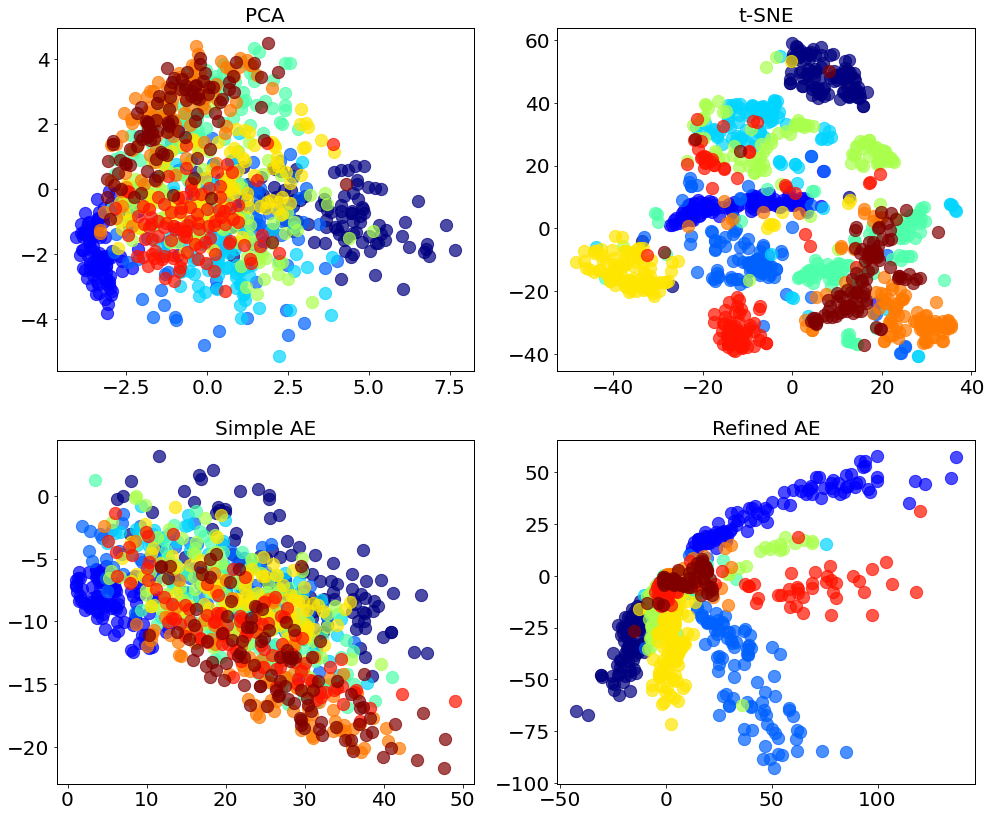

In [46]:
n_samples_plot = 100

plt.figure(figsize = (15, 15))
gs = gridspec.GridSpec(nrows = 2, ncols = 2, left = 0.1, bottom = 0.25, right = 0.95, top = 0.95,
                       wspace = 0.2, hspace = 0.2)

## PCA
ax1 = plt.subplot(gs[0])
for digit in range(0, 10):
    ind = np.where(l_train == digit)
    ind = ind[0][0:n_samples_plot]
    pca = dict_pca[2]
    Z0_train_pca = np.dot(X0_train, pca.components_.transpose())
    plt.scatter(Z0_train_pca[ind,0], Z0_train_pca[ind,1], label = str(digit), color =  colors[digit], alpha = 0.7, s = 150)
ax1.title.set_text("PCA")

## t-SNE
ax2 = plt.subplot(gs[1])
for digit in range(0, 10):
    ind = np.where(l_train == digit)
    ind = ind[0][0:n_samples_plot]
    plt.scatter(Z0_train_tsne[ind,0], Z0_train_tsne[ind,1], label = str(digit), color =  colors[digit], alpha = 0.7, s = 150)
ax2.title.set_text("t-SNE")

## Simple AE
arch = "2,Rlinear-784,sigmoid"
dict_encoder[arch] = Model(dict_model[arch].input, dict_model[arch].get_layer("representation").output)
Z_train_ = dict_encoder[arch].predict(X_train)
ax3 = plt.subplot(gs[2])
for digit in range(0, 10):
    ind = np.where(l_train == digit)
    ind = ind[0][0:n_samples_plot]
    plt.scatter(Z_train_[ind,0], Z_train_[ind,1], label = str(digit), color =  colors[digit], alpha = 0.7, s = 150)
ax3.title.set_text("Simple AE")

## Refined AE
arch = "512,elu-128,elu-2,Rlinear-128,elu-512,elu-784,sigmoid"
dict_encoder[arch] = Model(dict_model[arch].input, dict_model[arch].get_layer("representation").output)
Z_train_ = dict_encoder[arch].predict(X_train)
ax4 = plt.subplot(gs[3])
for digit in range(0, 10):
    ind = np.where(l_train == digit)
    ind = ind[0][0:n_samples_plot]
    plt.scatter(Z_train_[ind,0], Z_train_[ind,1], label = str(digit), color =  colors[digit], alpha = 0.7, s = 150)
ax4.title.set_text("Refined AE")


### Visualizing the reconstruction

Finally, we can visualize the reconstruction of our images to assess how well they are reconstructed.
For each $h$, we display:
- the original image,
- the PCA reconstruction,
- the simple autoencoder reconstruction,
- the refined autoencoder reconstruction.

1/1 [==============================] - 0s 60ms/step


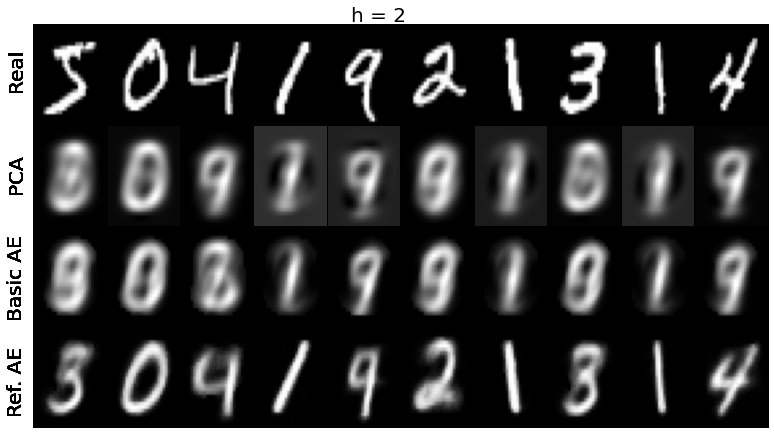

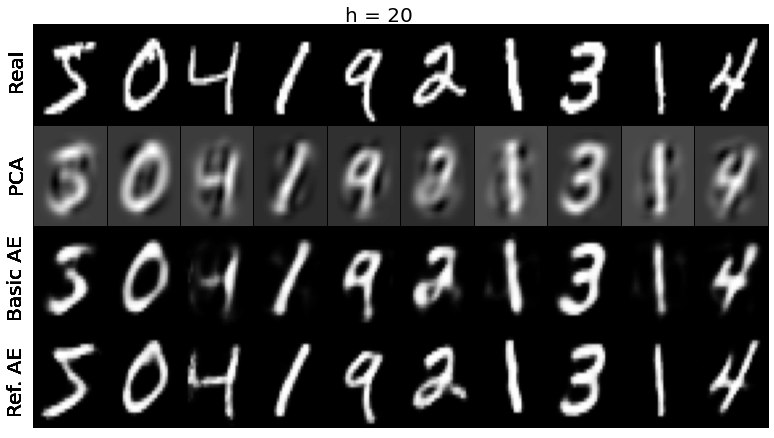

In [47]:
n_examples = 10

for h in hs:
    ## PCA
    pca = dict_pca[h]
    Z0_train_pca_ex = np.dot(X0_train[0:n_examples,:], pca.components_.transpose())
    Y0_train_pca_ex = np.dot(Z0_train_pca_ex[:,:h], pca.components_)
    Y_train_pca_ex = Y0_train_pca_ex + m_train
    Y_mat_train_pca_ex = Y_train_pca_ex.reshape(n_examples, n, n)
    ## Basic AE
    arch = str(h) + ",Rlinear-784,sigmoid"
    Y_train_bae_ex = dict_model[arch].predict(X_train[0:n_examples,:])
    Y_mat_train_bae_ex = Y_train_bae_ex.reshape(n_examples, n, n)
    ## Refined AE
    arch = "512,elu-128,elu-" + str(h) + ",Rlinear-128,elu-512,elu-784,sigmoid"
    Y_train_rae_ex = dict_model[arch].predict(X_train[0:n_examples,:])
    Y_mat_train_rae_ex = Y_train_rae_ex.reshape(n_examples, n, n)

    fig = plt.figure(figsize = (12, 8))
    gs = gridspec.GridSpec(nrows = 4, ncols = n_examples, left = 0.1, bottom = 0.25, right = 0.95, top = 0.95,
                           wspace = 0.0, hspace = 0.0)
    for i in range(0, n_examples):
        ## Real
        ax1 = plt.subplot(gs[i])
        plt.imshow(X_mat_train[i,:,:], cmap = "gray")
        ax1.set(adjustable = "datalim", aspect = "auto")
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)
        fig.text(0.07, 0.87, "Real", va = "center", rotation = "vertical")
        ## PCA
        ax2 = plt.subplot(gs[n_examples+i])
        plt.imshow(Y_mat_train_pca_ex[i,:,:], cmap = "gray")
        ax2.set(adjustable = "datalim", aspect = "auto")
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
        fig.text(0.07, 0.69, "PCA", va = "center", rotation = "vertical")
        ## Basic AE
        ax3 = plt.subplot(gs[2*n_examples+i])
        plt.imshow(Y_mat_train_bae_ex[i,:,:], cmap = "gray")
        ax3.set(adjustable = "datalim", aspect = "auto")
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)
        fig.text(0.07, 0.51, "Basic AE", va = "center", rotation = "vertical")
        ## Refined AE
        ax4 = plt.subplot(gs[3*n_examples+i])
        plt.imshow(Y_mat_train_rae_ex[i,:,:], cmap = "gray")
        ax4.set(adjustable = "datalim", aspect = "auto")
        ax4.get_xaxis().set_visible(False)
        ax4.get_yaxis().set_visible(False)
        fig.text(0.07, 0.33, "Ref. AE", va = "center", rotation = "vertical")
    plt.suptitle("h = " + str(h))

We again notice that:
- reconstructed images are much better with autoencoders than PCA,
- reconstructed images of the refined autoencoders are much better than those of the simple one, whence the importance of designing a good architecture of our autoencoders.

## Clustering

Now we are going to tackle the problem of clustering our representations to try to identify meaningful groups.
Usually we do not know how many clusters there are; here we are going to assume that we have $K = 10$ clusters.

We are going to use $K$-means to do so and initialize our centroids with the `kmeans++` method.
Note that we could also initialize randomly our centroids which might yield slightly better results in terms of clustering indices. You can try to set `n_random = 10` to launch $K$-means with such an initialization and see the results it yields.

For each architecture of our autoencoders, we are going to cluster the representation of our data and store the results in a dictionary `dict_kmeans`. We will also compute two internal clustering indices: the silhouette score and the Davies-Bouldin score. They will be stored in a `DataFrame` (using the `pandas` module) `df` that will sum up the clustering results for each architecture. Note that two different values of a score can be compared only if they are computed on the same data, i.e. the same representation. `DataFrames` are very practical for this task since you can then filter your results based on a condition (a given architecture, a given dimension of the representation, etc.) or find the maximum value of a given variable (e.g. the Davies-Bouldin index).

In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd

columns = ["arch", "h", "k", "init", "silhouette", "davies_bouldin"]
df = pd.DataFrame(columns = columns)

dict_kmeans = {}
n_random = 10
n_samples_kmeans = 10000    # set to 60000 if you want to take into account all data (longer training)
range_k = range(10, 11)     # we study results for k = 10 only, feel free to investigate further, range(5, 15) for instance

## the training of each architecture usually takes between 1 and 2 minutes with all data and n_random = 0

for h in hs:
    print("h:", h)
    for arch in [str(h) + ",Rlinear-784,sigmoid",
                 "512,elu-128,elu-" + str(h) + ",Rlinear-128,elu-512,elu-784,sigmoid"]:
        print("  arch:", arch)
        ti_clustering = time.time()
        dict_encoder[arch] = Model(dict_model[arch].input, dict_model[arch].get_layer("representation").output)
        Z_train = dict_encoder[arch].predict(X_train)
        Z_train = Z_train[0:n_samples_kmeans,:]
        dict_kmeans[arch] = {}
        for k in range_k:
            dict_kmeans[arch][k] = KMeans(n_clusters = k).fit(Z_train)
            sil = silhouette_score(Z_train, dict_kmeans[arch][k].labels_)
            db = davies_bouldin_score(Z_train, dict_kmeans[arch][k].labels_)
            df = df.append({"arch": arch, "h": h, "k": k, "init": "kmeans++", "silhouette": sil, "davies_bouldin": db},
                           ignore_index = True)
            for l in range(0, n_random):
                km = KMeans(n_clusters = k, init = "random").fit(Z_train)
                sil = silhouette_score(Z_train, km.labels_)
                db = davies_bouldin_score(Z_train, km.labels_)
                df = df.append({"arch": arch, "h": h, "k": k, "init": "random", "silhouette": sil, "davies_bouldin": db},
                               ignore_index = True)
        t_clustering = time.time() - ti_clustering
        print("Clustering time:", t_clustering)

h: 2
  arch: 2,Rlinear-784,sigmoid
1875/1875 [==============================] - 1s 665us/step


C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "kmeans++", "silhouette": sil, "davies_bouldin": db},
C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "random", "silhouette": sil, "davies_bouldin": db},
C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "random", "silhouette": sil, "davies_bouldin": db},
C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureW

Clustering time: 18.70631504058838
  arch: 512,elu-128,elu-2,Rlinear-128,elu-512,elu-784,sigmoid
  46/1875 [..............................] - ETA: 2s  

C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "random", "silhouette": sil, "davies_bouldin": db},


1875/1875 [==============================] - 2s 1ms/step


C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "kmeans++", "silhouette": sil, "davies_bouldin": db},
C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "random", "silhouette": sil, "davies_bouldin": db},
C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "random", "silhouette": sil, "davies_bouldin": db},
C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureW

Clustering time: 18.81152081489563
h: 20
  arch: 20,Rlinear-784,sigmoid
 136/1875 [=>............................] - ETA: 1s

C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "random", "silhouette": sil, "davies_bouldin": db},


1875/1875 [==============================] - 1s 672us/step


C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "kmeans++", "silhouette": sil, "davies_bouldin": db},
C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "random", "silhouette": sil, "davies_bouldin": db},
C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "random", "silhouette": sil, "davies_bouldin": db},
C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureW

Clustering time: 18.74326205253601
  arch: 512,elu-128,elu-20,Rlinear-128,elu-512,elu-784,sigmoid
  43/1875 [..............................] - ETA: 2s  

C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "random", "silhouette": sil, "davies_bouldin": db},


1875/1875 [==============================] - 2s 1ms/step


C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "kmeans++", "silhouette": sil, "davies_bouldin": db},
C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "random", "silhouette": sil, "davies_bouldin": db},
C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "random", "silhouette": sil, "davies_bouldin": db},
C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureW

Clustering time: 19.052540063858032


C:\Users\macxp\AppData\Local\Temp\ipykernel_48080\380820038.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"arch": arch, "h": h, "k": k, "init": "random", "silhouette": sil, "davies_bouldin": db},


The clustering results stored in `df` are now available.

In [49]:
df.head()

,arch,h,k,init,silhouette,davies_bouldin
0,"2,Rlinear-784,sigmoid",2,10,kmeans++,0.3546,0.827245
1,"2,Rlinear-784,sigmoid",2,10,random,0.355524,0.82552
2,"2,Rlinear-784,sigmoid",2,10,random,0.355789,0.825033
3,"2,Rlinear-784,sigmoid",2,10,random,0.354916,0.825967
4,"2,Rlinear-784,sigmoid",2,10,random,0.355335,0.82598


We could define functions to retrieve only the lines that correspond, for instance, to a particular architecture and a number of clusters. We could also find the case for which the silhouette (resp. Davies-Bouldin) index is maximal (resp. minimal). This is useful if we have several clustering algorithms for the same case (i.e. initializing $K$-means with different initializations).

In [50]:
def select(df, arch, k): return df[(df["arch"] == arch) & (df["k"] == k)]
def silhouette_max(df): return df.loc[df["silhouette"].idxmax()].silhouette
def davies_bouldin_min(df): return df.loc[df["davies_bouldin"].idxmin()].davies_bouldin

arch = "2,Rlinear-784,sigmoid"
k = 10
df_filtered = select(df, arch, k)
sil_max = silhouette_max(df_filtered)
db_min = davies_bouldin_min(df_filtered)

print(df_filtered)
print("\n")
print("Maximum silhouette score for", arch, ":", sil_max)
print("Minimum Davies-Bouldin score for", arch, ":", db_min)

TypeError: reduction operation 'argmax' not allowed for this dtype

We can also display the evolution of the clustering indices with the number of clusters. This will obviously work only if you have set `range_k` to include several values.

In [ ]:
for h in hs:
    for arch in [str(h) + ",Rlinear-784,sigmoid",
                 "512,elu-128,elu-" + str(h) + ",Rlinear-128,elu-512,elu-784,sigmoid"]:
        vec_k = np.zeros(0)
        vec_sil = np.zeros(0)
        vec_db = np.zeros(0)
        for k in range_k:
            vec_k = np.append(vec_k, k)
            vec_sil = np.append(vec_sil, silhouette_max(select(df, arch, k)))
            vec_db = np.append(vec_db, davies_bouldin_min(select(df, arch, k)))
        plt.figure(figsize = (15, 5))
        plt.plot(vec_k, vec_db)
        plt.xlabel("Number of clusters")
        plt.ylabel("Davies-Bouldin index")
        plt.title(arch)

Clustering is a rather hard problem, and having to cluster data from representations may yield clusters composed of different types of objects. Here, since the MNIST dataset is labelled, we can investigate the different allocations of digits within the clusters that we have found, and see which digits are harder to discriminate.

We are going to investigate, for each cluster $0 \leq c \leq 9$ and digit $0 \leq d \leq 9$, how many digits $d$ we have found in cluster $c$, and store the results inside a `DataFrame` `df_allocation`.

This will provide us with raw counts of digits per cluster. We also define another `DataFrame` `df_allocation_relative` in which we divide each number of digits $d$ in cluster $c$ by the total number of digits in cluster $c$ so as to obtain the proportions of each digit in a given cluster.

Results can then be printed or displayed as heatmaps using the `seaborn` module, which makes it visually easy to understand of what digits the different clusters are mainly made.

In [ ]:
import pandas as pd
import seaborn as sns

dict_df_allocation = {}
dict_df_allocation_relative = {}

list_digits = list(map(lambda d: str(d), range(0,10)))

for h in hs:
    for arch in [str(h) + ",Rlinear-784,sigmoid",
                 "512,elu-128,elu-" + str(h) + ",Rlinear-128,elu-512,elu-784,sigmoid"]:
        labels = dict_kmeans[arch][10].labels_ ## we focus on the case k = 10
        df_allocation = pd.DataFrame(columns = ["cluster"] + list_digits + ["total"])
        for c in range(0, 10):
            ind = np.where(labels == c)
            counts = np.zeros(10, dtype = int)
            for d in range(0, 10):
                counts[d] = np.where(l_train[ind] == d)[0].size
            df_allocation.loc[c] = np.concatenate([c, counts, np.sum(counts)], axis = None)
        dict_df_allocation[arch] = df_allocation
        df_allocation_relative = df_allocation.copy()
        for c in range(0, 10):
            for d in list_digits:
                df_allocation_relative[d][c] /= df_allocation["total"][c]
            df_allocation_relative["total"][c] = np.sum(df_allocation_relative[list_digits].iloc[c])
        dict_df_allocation_relative[arch] = df_allocation_relative
        for digit in list_digits:
            df_allocation_relative[digit] = df_allocation_relative[digit].apply(lambda x: str(round(x, 2)))
        print("Arch:", arch)
        print("\n")
        print(df_allocation_relative)
        print("\n")
        data = dict_df_allocation_relative[arch][list_digits].as_matrix().astype(float)
        fig = plt.figure(figsize = (8, 6))
        sns.heatmap(data)
        plt.ylabel("Clusters")
        plt.xlabel("Digits")
        plt.suptitle(arch)

You can then identify if each cluster (i.e. each row) is composed of more digits than some others.